In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-data/stock_data.pkl


In [2]:
!pip install numba --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 42.5 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninstalled numba-0.60.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.2.0 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
cuml-cu12 25.2.0 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
dask-cuda 25.2.0 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
distributed-ucxx-cu12 0.42.0 requires numba<0.61.0a0,>=

In [3]:
pip install --upgrade numba cudatoolkit

ERROR: Ignored the following versions that require a different python version: 0.52.0 Requires-Python >=3.6,<3.9; 0.52.0rc3 Requires-Python >=3.6,<3.9; 0.53.0 Requires-Python >=3.6,<3.10; 0.53.0rc1.post1 Requires-Python >=3.6,<3.10; 0.53.0rc2 Requires-Python >=3.6,<3.10; 0.53.0rc3 Requires-Python >=3.6,<3.10; 0.53.1 Requires-Python >=3.6,<3.10; 0.54.0 Requires-Python >=3.7,<3.10; 0.54.0rc2 Requires-Python >=3.7,<3.10; 0.54.0rc3 Requires-Python >=3.7,<3.10; 0.54.1 Requires-Python >=3.7,<3.10
ERROR: Could not find a version that satisfies the requirement cudatoolkit (from versions: none)
ERROR: No matching distribution found for cudatoolkit
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time
from tqdm import tqdm
import numba
from numba import cuda, float32, int32, jit
import cupy as cp
import warnings
import numpy as np
from numba import cuda, float32, int32
from numba.cuda import random as curand
import math


warnings.filterwarnings('ignore')



In [5]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

CUDA available: True
CUDA device: Tesla T4


In [6]:
# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configuration
NUM_SIMULATIONS = 10000  # Number of Monte Carlo simulations
PREDICTION_DAYS = 252     # Trading days in a year
SYMBOLS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'WMT']
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'WMT']


import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Settings
np.random.seed(42)
#tickers = ["ABC", "DEF", "TUV", "XYZ", "PQR"]
start_date = datetime(2000, 1, 1)
days = 9131



import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm  # Assuming tqdm is still intended for progress tracking

# Settings
np.random.seed(42)
#tickers = ["ABC", "DEF", "TUV", "XYZ", "PQR"]
start_date = datetime(2000, 1, 1)
days = 9131

# Generate correlated random walks (modified to fit the original function's purpose)
def load_stock_data(symbols, start_date=datetime(2005, 1, 1), end_date=datetime(2025, 4, 12)):
    print(f"Generating synthetic historical data for {len(symbols)} stocks...")
    stock_data = {}
    
    # Ensure we have business days only
    dates = pd.date_range(start_date, end_date, freq='B')
    
    for symbol in tqdm(symbols):
        try:
            # Set realistic initial prices
            base_prices = {
                "AAPL": 150.00, "MSFT": 300.00, "GOOGL": 2800.00,
                "AMZN": 3300.00, "META": 300.00, "TSLA": 800.00,
                "NVDA": 250.00, "JPM": 150.00, "JNJ": 170.00, "WMT": 140.00
            }
            
            if symbol in base_prices:
                start_price = base_prices[symbol]
                # Add trend and volatility
                volatility = 0.02
                drift = 0.0001  # small upward drift
                
                # Generate returns
                returns = np.random.normal(drift, volatility, len(dates))
                # Calculate prices
                prices = start_price * np.exp(np.cumsum(returns))
                
                # Create DataFrame with proper date index
                data = pd.DataFrame({
                    'Adj Close': prices,
                    'Date': dates
                }).set_index('Date')
                
                stock_data[symbol] = data
            
        except Exception as e:
            print(f"Error generating data for {symbol}: {e}")
    
    print(f"Successfully generated synthetic data for {len(stock_data)} stocks")
    print(stock_data)
    return stock_data

# Example usage (adjust end_date as needed)
end_date = datetime(2025, 4, 12)
synthetic_stock_data = load_stock_data(tickers, start_date, end_date)
import pickle

# After generating the data:
def save_stock_data(data, filename='stock_data.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)




Generating synthetic historical data for 10 stocks...


100%|██████████| 10/10 [00:00<00:00, 509.70it/s]

Successfully generated synthetic data for 10 stocks
{'AAPL':              Adj Close
Date                  
2000-01-03  151.512719
2000-01-04  151.109432
2000-01-05  153.094911
2000-01-06  157.845808
2000-01-07  157.124045
...                ...
2025-04-07  173.974087
2025-04-08  169.940969
2025-04-09  175.028150
2025-04-10  172.880640
2025-04-11  166.650047

[6595 rows x 1 columns], 'MSFT':              Adj Close
Date                  
2000-01-03  308.106590
2000-01-04  305.045161
2000-01-05  301.389473
2000-01-06  290.962853
2000-01-07  301.302407
...                ...
2025-04-07  471.767999
2025-04-08  463.967666
2025-04-09  475.089570
2025-04-10  483.345902
2025-04-11  483.260240

[6595 rows x 1 columns], 'GOOGL':                 Adj Close
Date                     
2000-01-03    2752.240304
2000-01-04    2710.546106
2000-01-05    2682.879837
2000-01-06    2589.011022
2000-01-07    2537.823057
...                   ...
2025-04-07  107650.370168
2025-04-08  107961.332477
2025-04-09  

In [7]:
# Calculate log returns and statistics
def calculate_stock_statistics(stock_data):
    stats = {}
    for symbol, data in stock_data.items():
        # Calculate daily returns
        data['Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
        
        # Remove NaN values
        returns = data['Returns'].dropna()
        
        # Calculate statistics
        daily_mean = returns.mean()
        daily_std = returns.std()
        
        stats[symbol] = {
            'mean': daily_mean,
            'std': daily_std,
            'last_price': data['Adj Close'].iloc[-1],
            'returns': returns
        }
    
    return stats

# CPU Implementation of Monte Carlo Simulation
def monte_carlo_simulation_cpu(initial_price, daily_return, daily_volatility, days, num_simulations):
    # Initialize an array to store simulations
    simulations = np.zeros((days, num_simulations))
    
    # Set the initial price for all simulations
    simulations[0] = initial_price
    
    # Run the simulation
    for sim in range(num_simulations):
        for day in range(1, days):
            # Generate random shock
            shock = np.random.normal(0, 1)
            # Calculate the daily return with random shock
            daily_return_shock = daily_return + (daily_volatility * shock)
            # Calculate the price for the day
            simulations[day, sim] = simulations[day-1, sim] * np.exp(daily_return_shock)
    
    return simulations

# GPU Implementation using CUDA with Numba
@cuda.jit
def monte_carlo_kernel(rng_states, sim_results, initial_price, daily_return, daily_volatility, days):
    # Get thread ID
    thread_id = cuda.grid(1)
    
    # Check if thread should run
    if thread_id < sim_results.shape[1]:
        # Set initial price
        sim_results[0, thread_id] = initial_price
        
        # Random number generator for this thread
        rand_normal = numba.cuda.random.xoroshiro128p_normal_float32
        
        # Run simulation for this thread
        for day in range(1, days):
            # Generate random shock
            shock = rand_normal(rng_states, thread_id)
            # Calculate daily return with random shock
            daily_return_shock = daily_return + (daily_volatility * shock)
            # Calculate price for the day
            sim_results[day, thread_id] = sim_results[day-1, thread_id] * math.exp(daily_return_shock)


def monte_carlo_simulation_gpu(initial_price, daily_return, daily_volatility, days, num_simulations):
    threads_per_block = 256
    blocks = (num_simulations + threads_per_block - 1) // threads_per_block

    rng_states = curand.create_xoroshiro128p_states(threads_per_block * blocks, seed=np.random.randint(10000))

    sim_results = np.zeros((days, num_simulations), dtype=np.float32)
    d_sim_results = cuda.to_device(sim_results)

    monte_carlo_kernel[blocks, threads_per_block](
        rng_states,
        d_sim_results,
        float32(initial_price),
        float32(daily_return),
        float32(daily_volatility),
        int32(days)
    )

    sim_results = d_sim_results.copy_to_host()
    return sim_results


# Function to run simulations for all stocks
def run_all_simulations(stock_stats, prediction_days, num_simulations, use_gpu=True):
    results = {}
    execution_times = {}
    
    print(f"Running {'GPU' if use_gpu else 'CPU'} simulations for {len(stock_stats)} stocks...")
    
    for symbol, stats in tqdm(stock_stats.items()):
        start_time = time.time()
        
        # Choose simulation function based on use_gpu flag
        if use_gpu:
            simulations = monte_carlo_simulation_gpu(
                stats['last_price'], 
                stats['mean'], 
                stats['std'], 
                prediction_days, 
                num_simulations
            )
        else:
            simulations = monte_carlo_simulation_cpu(
                stats['last_price'], 
                stats['mean'], 
                stats['std'], 
                prediction_days, 
                num_simulations
            )
        
        end_time = time.time()
        execution_time = end_time - start_time
        
        results[symbol] = simulations
        execution_times[symbol] = execution_time
    
    return results, execution_times



In [8]:
# Function to visualize simulation results

def visualize_simulation_results(stock_data, simulation_results, prediction_days):
    for symbol, simulations in simulation_results.items():
        plt.figure(figsize=(14, 8))
        
        # Plot historical data
        historical_prices = stock_data[symbol]['Adj Close']
        plt.plot(historical_prices.index[-252:], historical_prices[-252:], 
                label='Historical', color='black', linewidth=2)
        
        # Plot future dates
        last_date = historical_prices.index[-1]
        future_dates = pd.date_range(start=last_date, 
                                   periods=prediction_days+1, 
                                   freq='B')[1:]
        
        # Plot simulations
        for i in range(0, min(100, simulations.shape[1]), 5):
            plt.plot(future_dates, simulations[:, i], alpha=0.1, color='cyan')
        
        # Plot mean prediction
        mean_simulation = np.mean(simulations, axis=1)
        plt.plot(future_dates, mean_simulation, 
                label='Mean Prediction', color='blue', linewidth=2)
        
        # Plot confidence intervals
        percentiles = np.percentile(simulations, [5, 95], axis=1)
        plt.fill_between(future_dates, percentiles[0, :], percentiles[1, :], 
                        color='blue', alpha=0.1, label='95% CI')
        
        plt.title(f'Monte Carlo Simulation for {symbol}', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Stock Price ($)', fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



def visualize_market_prediction(stock_data, simulation_results, prediction_days):
    plt.figure(figsize=(14, 8))
    
    # Create a market index by averaging normalized stock prices
    market_data = {}
    
    # Get list of all dates across all stocks
    all_dates = set()
    for symbol in stock_data:
        all_dates.update(stock_data[symbol].index)
    
    # Sort dates
    all_dates = sorted(all_dates)
    
    # Create a DataFrame with all dates
    market_df = pd.DataFrame(index=all_dates)
    
    # Add normalized stock prices to the DataFrame
    for symbol in stock_data:
        prices = stock_data[symbol]['Adj Close']
        normalized_prices = prices / prices.iloc[0]  # Normalize to starting price
        market_df[symbol] = normalized_prices
    
    # Calculate market index as the average of normalized prices
    market_df['Market'] = market_df.mean(axis=1)
    
    # Plot historical market index
    plt.plot(market_df.index[-252:], market_df['Market'].iloc[-252:], label='Historical Market Index', color='black', linewidth=2)
    
    # Calculate future market index from simulations
    last_date = market_df.index[-1]
    future_dates = [last_date + timedelta(days=i) for i in range(prediction_days)]
    
    # Initialize future market index: shape (252, NUM_SIMULATIONS)
    future_market = np.zeros((prediction_days, NUM_SIMULATIONS))
    
    for symbol in simulation_results:
        simulations = simulation_results[symbol]  # shape: (252, NUM_SIMULATIONS)
        last_actual = stock_data[symbol]['Adj Close'].iloc[-1]
        
        # Normalize simulations by last actual price
        rel_changes = simulations / last_actual  # shape: (252, NUM_SIMULATIONS)
        
        future_market += rel_changes / len(simulation_results)  # Equal weighting
    
    # Plot a subset of market simulations
    for i in range(0, min(100, NUM_SIMULATIONS), 5):
        plt.plot(future_dates, future_market[:, i], alpha=0.1, color='cyan')
    
    # Plot mean market prediction
    mean_market = np.mean(future_market, axis=1)
    plt.plot(future_dates, mean_market, label='Mean Market Prediction', color='blue', linewidth=2)
    
    # Plot 95% confidence intervals
    percentiles = np.percentile(future_market, [5, 95], axis=1)
    plt.fill_between(future_dates, percentiles[0, :], percentiles[1, :], color='blue', alpha=0.1, label='95% CI')
    
    plt.title('Monte Carlo Simulation for Market Index', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Normalized Market Index', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('market_simulation.png')
    plt.show()
    plt.close()




In [9]:
# Function to compare CPU and GPU performance
def compare_performance(cpu_times, gpu_times):
    plt.figure(figsize=(14, 8))
    
    symbols = list(cpu_times.keys())
    cpu_execution = [cpu_times[sym] for sym in symbols]
    gpu_execution = [gpu_times[sym] for sym in symbols]
    
    # Calculate speedup
    speedup = [cpu / gpu for cpu, gpu in zip(cpu_execution, gpu_execution)]
    
    x = np.arange(len(symbols))
    width = 0.35
    
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Plot execution times
    bar1 = ax1.bar(x - width/2, cpu_execution, width, label='CPU Execution Time', color='royalblue')
    bar2 = ax1.bar(x + width/2, gpu_execution, width, label='GPU Execution Time', color='orangered')
    
    ax1.set_xlabel('Stocks', fontsize=14)
    ax1.set_ylabel('Execution Time (seconds)', fontsize=14)
    ax1.set_title('CPU vs GPU Performance Comparison', fontsize=16)
    ax1.set_xticks(x)
    ax1.set_xticklabels(symbols, rotation=45)
    ax1.legend(loc='upper left')
    
    # Create second y-axis for speedup
    ax2 = ax1.twinx()
    line = ax2.plot(x, speedup, 'go-', linewidth=2, markersize=8, label='Speedup (CPU/GPU)')
    ax2.set_ylabel('Speedup Factor (CPU/GPU)', fontsize=14)
    ax2.legend(loc='upper right')
    
    # Add text annotations for speedup values
    for i, v in enumerate(speedup):
        ax2.text(i, v + 0.5, f"{v:.1f}x", ha='center', fontsize=10)
    
    fig.tight_layout()
    plt.savefig('performance_comparison.png')
    plt.close()


In [10]:
# def portfolio_optimization(simulation_results, num_portfolios=10000):
#     print("Running portfolio optimization based on Monte Carlo simulations...")
    
#     expected_returns = {}
#     volatilities = {}

#     for symbol, simulations in simulation_results.items():
#         initial_price = simulations[0, 0]
#         final_prices = simulations[-1, :]
#         returns = (final_prices - initial_price) / initial_price
#         annual_returns = returns * (252 / PREDICTION_DAYS)
#         expected_returns[symbol] = np.mean(annual_returns)
#         volatilities[symbol] = np.std(annual_returns)

#     symbols = list(expected_returns.keys())
#     returns_array = np.array([expected_returns[sym] for sym in symbols])

#     weights_matrix = np.random.random((num_portfolios, len(symbols)))
#     weights_matrix = weights_matrix / weights_matrix.sum(axis=1).reshape(-1, 1)
#     portfolio_returns = np.dot(weights_matrix, returns_array)

#     returns_data = {}
#     for symbol, simulations in simulation_results.items():
#         initial_price = simulations[0, 0]
#         prices = simulations[:, :100]
#         returns = np.diff(prices, axis=0) / prices[:-1, :]
#         returns_data[symbol] = returns.mean(axis=1)

#     returns_df = pd.DataFrame(returns_data)
#     cov_matrix = returns_df.cov() * PREDICTION_DAYS

#     portfolio_volatilities = []
#     for weights in weights_matrix:
#         portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
#         portfolio_volatilities.append(portfolio_vol)
    
#     portfolio_volatilities = np.array(portfolio_volatilities)
#     sharpe_ratios = portfolio_returns / portfolio_volatilities
#     max_sharpe_idx = np.argmax(sharpe_ratios)
#     optimal_weights = weights_matrix[max_sharpe_idx]

#     # Generate only the pie chart of optimal portfolio weights
#     plt.figure(figsize=(12, 9))
#     wedges, texts, autotexts = plt.pie(
#         optimal_weights, autopct='%1.1f%%', startangle=90, explode=[0.05]*len(symbols)
#     )
#     plt.legend(wedges, symbols, title="Stocks", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
#     plt.title('Optimal Portfolio Weights', fontsize=16)
#     plt.axis('equal')
#     plt.tight_layout()
#     plt.savefig('optimal_portfolio.png')
#     plt.show()
#     plt.close()

#     return {
#         'weights': {sym: weight for sym, weight in zip(symbols, optimal_weights)},
#         'return': portfolio_returns[max_sharpe_idx],
#         'volatility': portfolio_volatilities[max_sharpe_idx],
#         'sharpe_ratio': sharpe_ratios[max_sharpe_idx]
#     }


import cupy as cp
import matplotlib.pyplot as plt
import pandas as pd

def portfolio_optimization(simulation_results, num_portfolios=10000):
    print("Running portfolio optimization based on Monte Carlo simulations...")
    
    expected_returns = {}
    volatilities = {}

    # Convert simulation results to CuPy arrays
    simulation_results_cp = {k: cp.array(v) for k, v in simulation_results.items()}

    for symbol, simulations in simulation_results_cp.items():
        initial_price = simulations[0, 0]
        final_prices = simulations[-1, :]
        returns = (final_prices - initial_price) / initial_price
        annual_returns = returns * (252 / PREDICTION_DAYS)
        expected_returns[symbol] = cp.mean(annual_returns).get()
        volatilities[symbol] = cp.std(annual_returns).get()

    symbols = list(expected_returns.keys())
    returns_array = cp.array([expected_returns[sym] for sym in symbols])

    # Generate random weights on GPU
    weights_matrix = cp.random.random((num_portfolios, len(symbols)))
    weights_matrix = weights_matrix / weights_matrix.sum(axis=1).reshape(-1, 1)
    portfolio_returns = cp.dot(weights_matrix, returns_array)

    # Calculate covariance matrix
    returns_data = {}
    for symbol, simulations in simulation_results_cp.items():
        initial_price = simulations[0, 0]
        prices = simulations[:, :100]  # Using first 100 simulations for covariance
        returns = cp.diff(prices, axis=0) / prices[:-1, :]
        returns_data[symbol] = returns.mean(axis=1).get()  # Bring back to CPU for pandas
    
    returns_df = pd.DataFrame(returns_data)
    cov_matrix = cp.array(returns_df.cov() * PREDICTION_DAYS)

    # Calculate portfolio volatilities on GPU
    portfolio_volatilities = []
    for weights in weights_matrix:
        portfolio_vol = cp.sqrt(cp.dot(weights.T, cp.dot(cov_matrix, weights)))
        portfolio_volatilities.append(portfolio_vol)
    
    portfolio_volatilities = cp.array(portfolio_volatilities)
    sharpe_ratios = portfolio_returns / portfolio_volatilities
    
    # Find optimal portfolio
    max_sharpe_idx = cp.argmax(sharpe_ratios).get()
    optimal_weights = weights_matrix[max_sharpe_idx].get()

    # Generate the pie chart of optimal portfolio weights
    plt.figure(figsize=(12, 9))
    wedges, texts, autotexts = plt.pie(
        optimal_weights, autopct='%1.1f%%', startangle=90, explode=[0.05]*len(symbols)
    )
    plt.legend(wedges, symbols, title="Stocks", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.title('Optimal Portfolio Weights', fontsize=16)
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('optimal_portfolio.png')
    plt.show()
    plt.close()

    return {
        'weights': {sym: weight for sym, weight in zip(symbols, optimal_weights)},
        'return': portfolio_returns[max_sharpe_idx].get(),
        'volatility': portfolio_volatilities[max_sharpe_idx].get(),
        'sharpe_ratio': sharpe_ratios[max_sharpe_idx].get()
    }


In [11]:
def load_saved_stock_data(filename='stock_data.pkl'):
    with open(filename, 'rb') as f:
        return pickle.load(f)

Starting Monte Carlo Stock Price Simulation with CUDA
Number of simulations: 10000
Prediction horizon: 252 days

--- Running CPU Simulations ---
Running CPU simulations for 10 stocks...


100%|██████████| 10/10 [00:54<00:00,  5.44s/it]



--- Running GPU Simulations with CUDA ---
Running GPU simulations for 10 stocks...


100%|██████████| 10/10 [00:01<00:00,  5.34it/s]



--- Comparing Performance ---
Total CPU time: 54.44s
Total GPU time: 1.87s
Overall speedup: 29.12x

--- Generating Visualizations ---


<Figure size 1400x800 with 0 Axes>

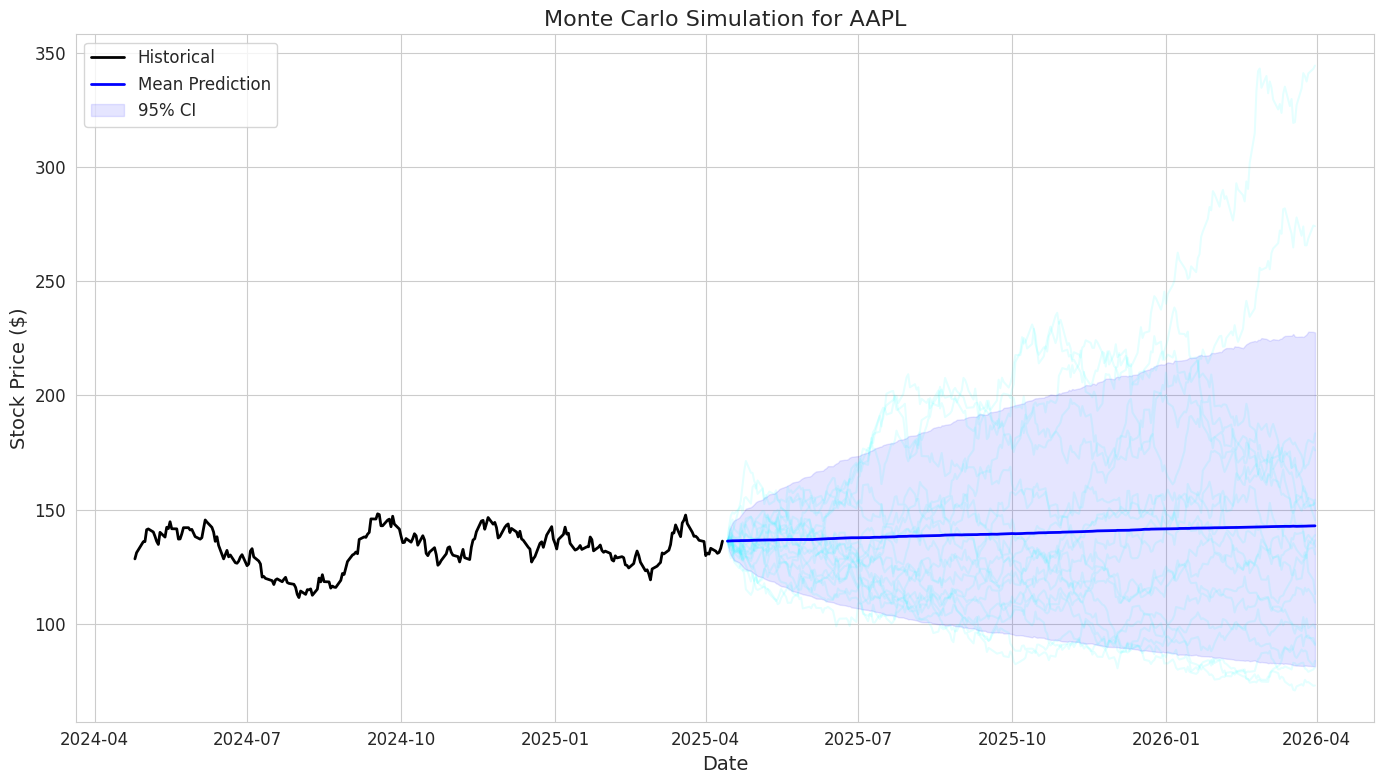

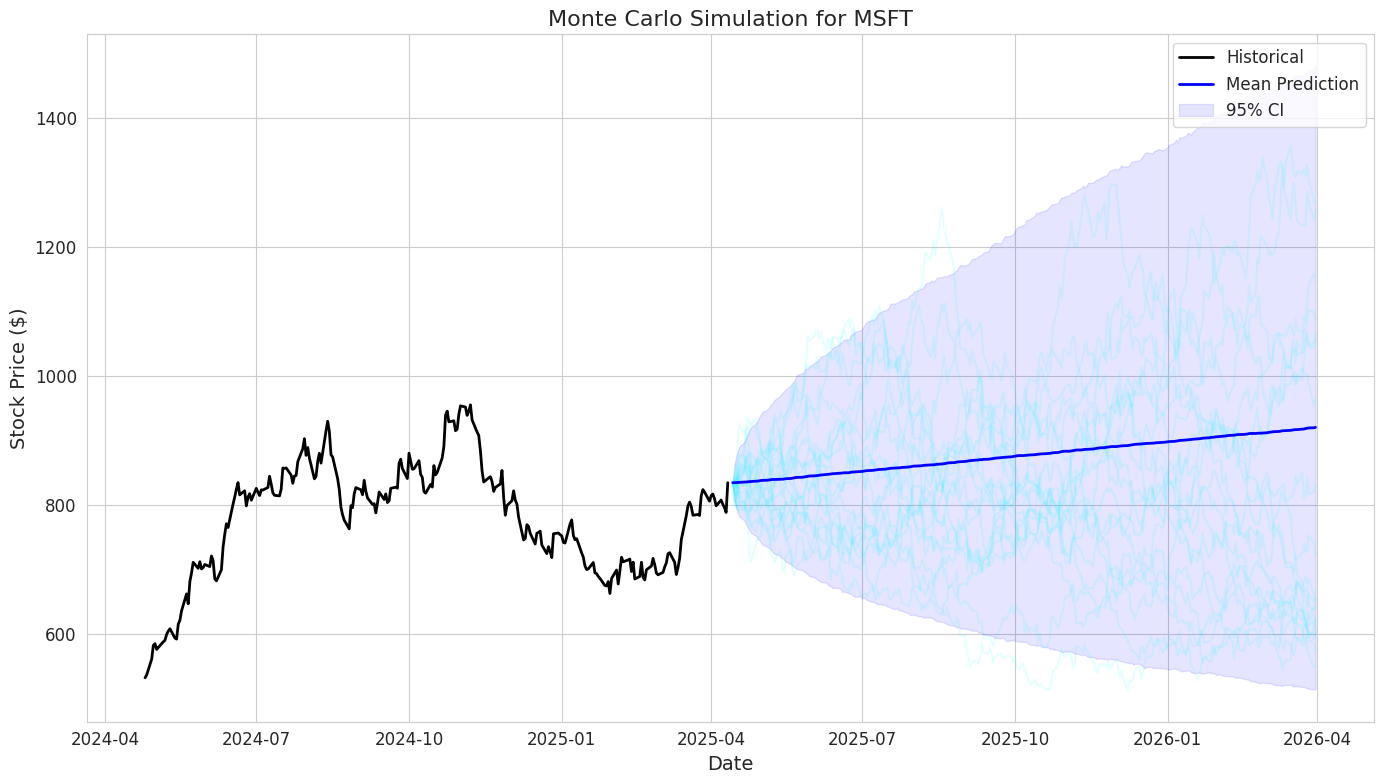

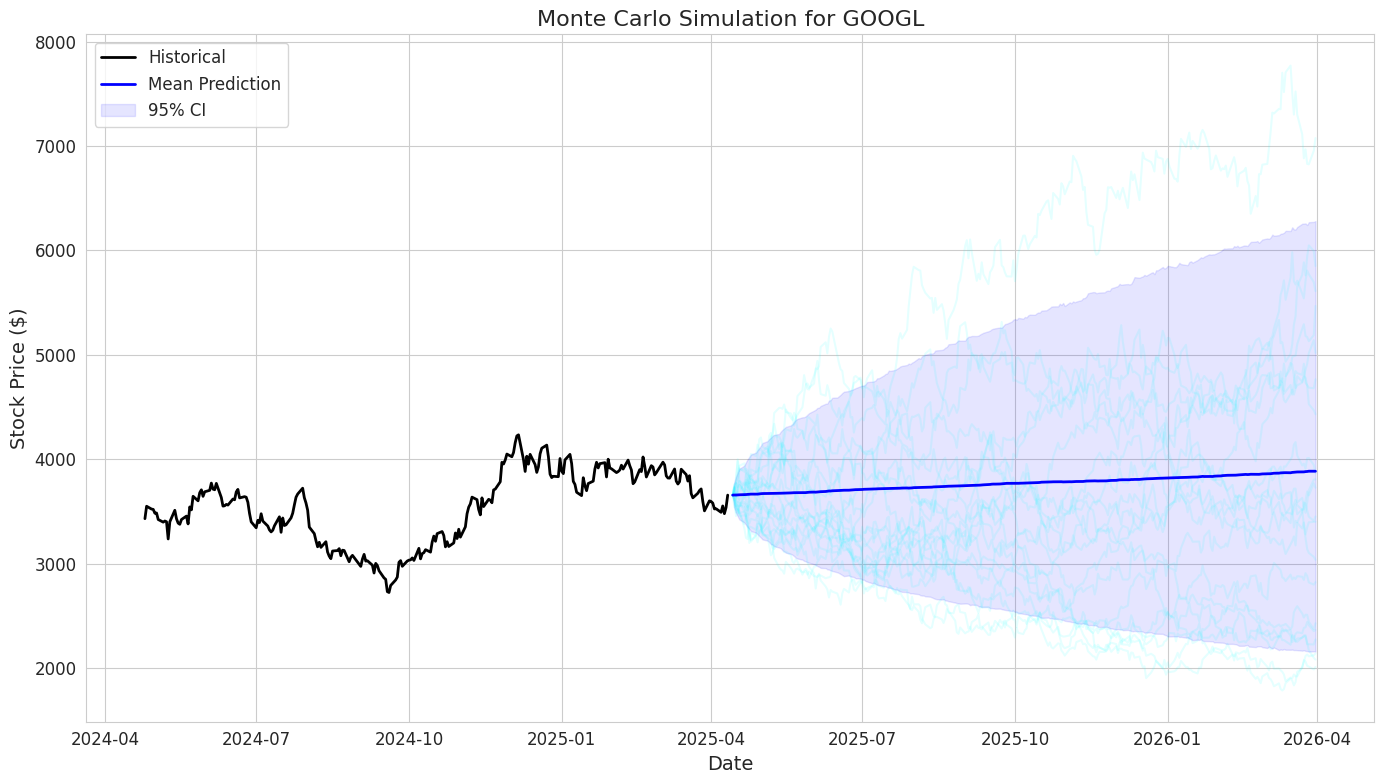

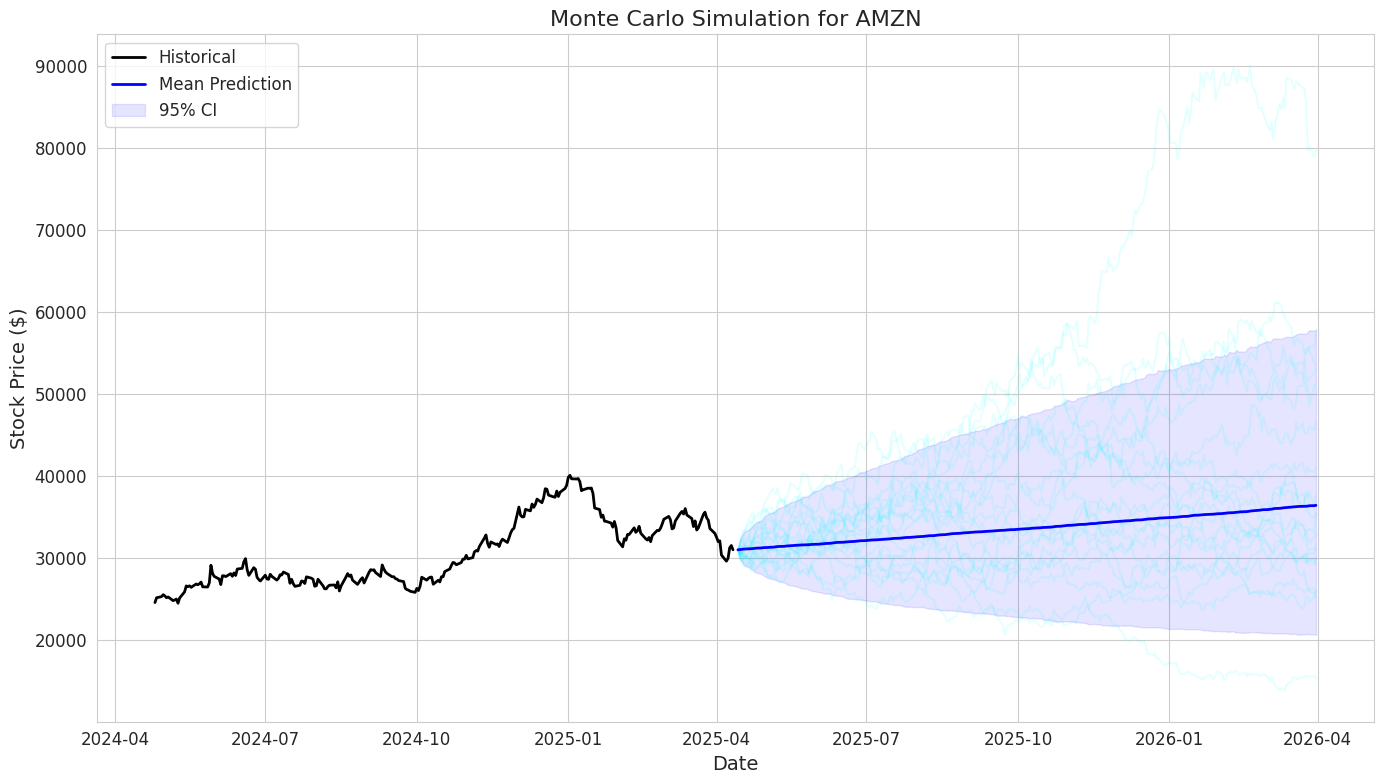

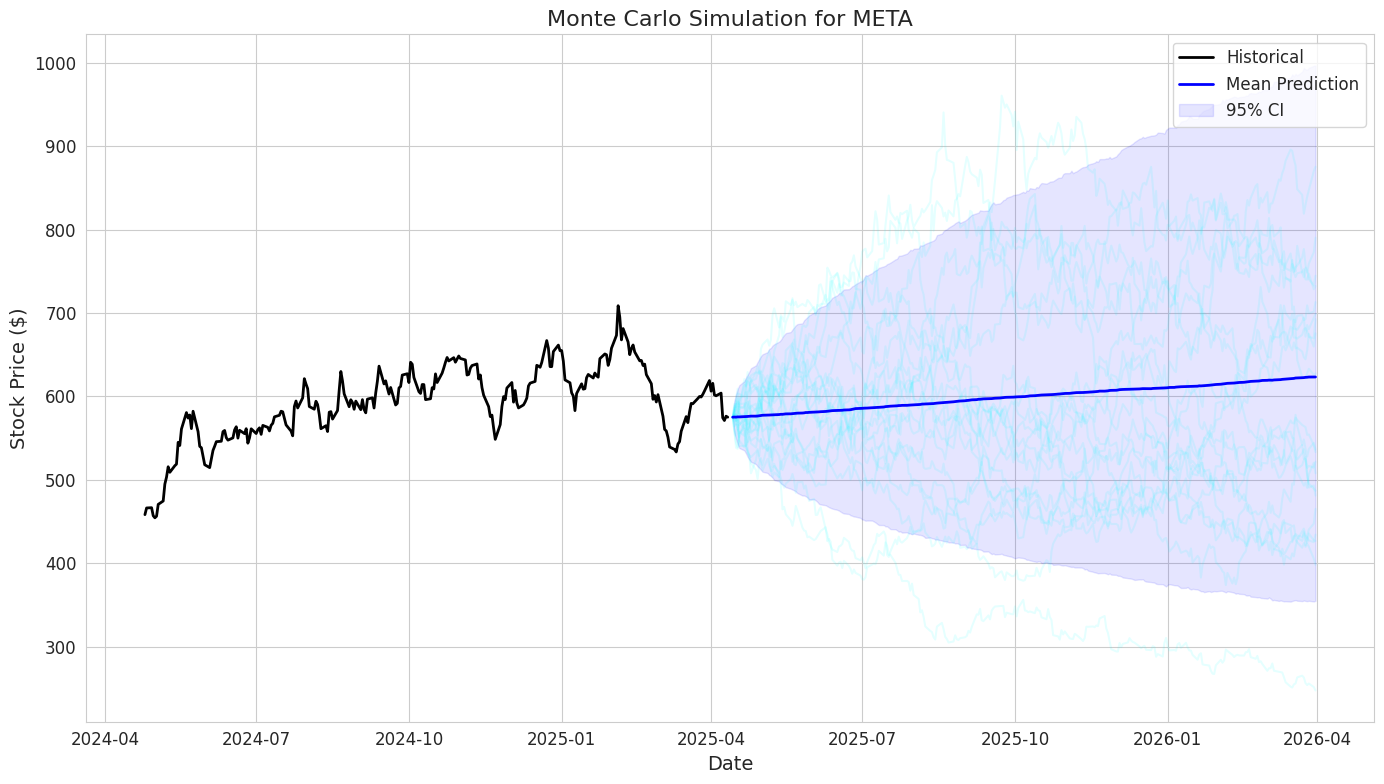

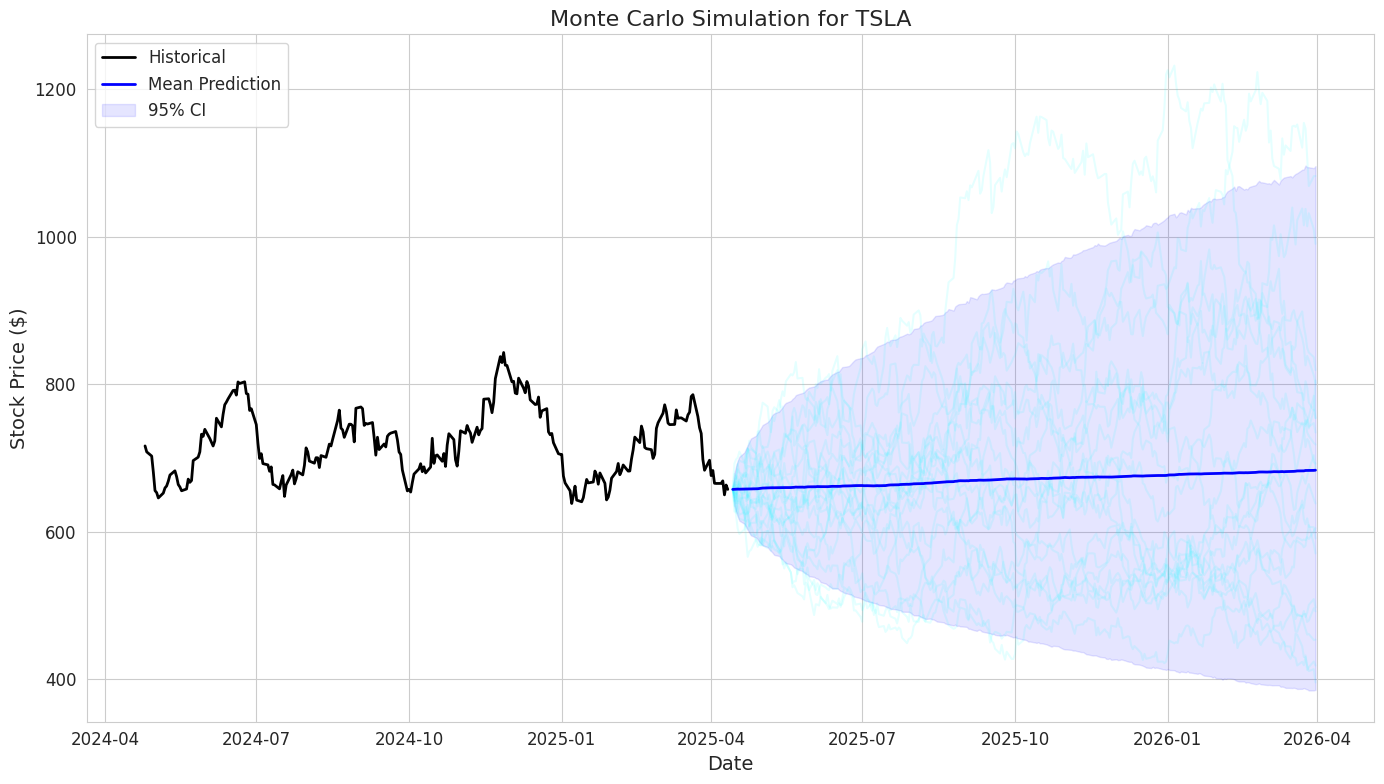

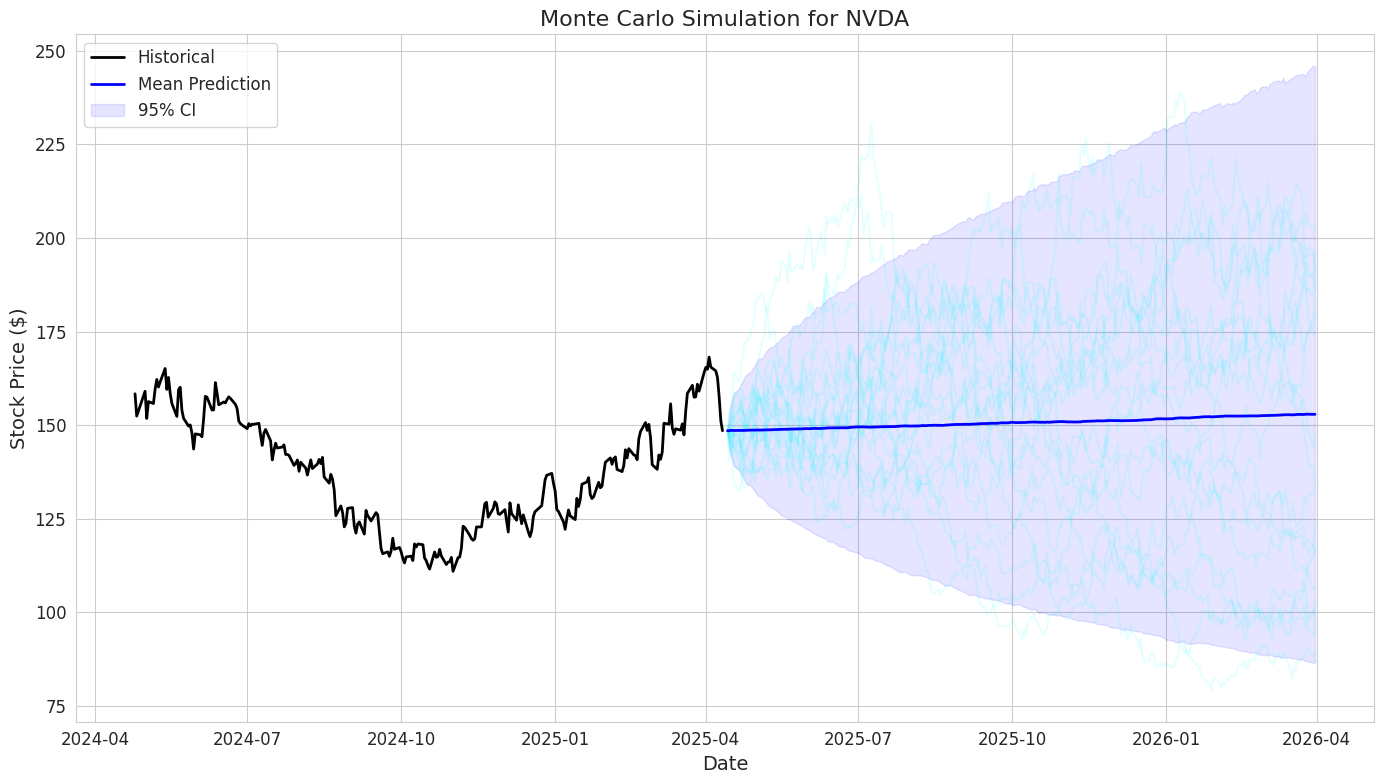

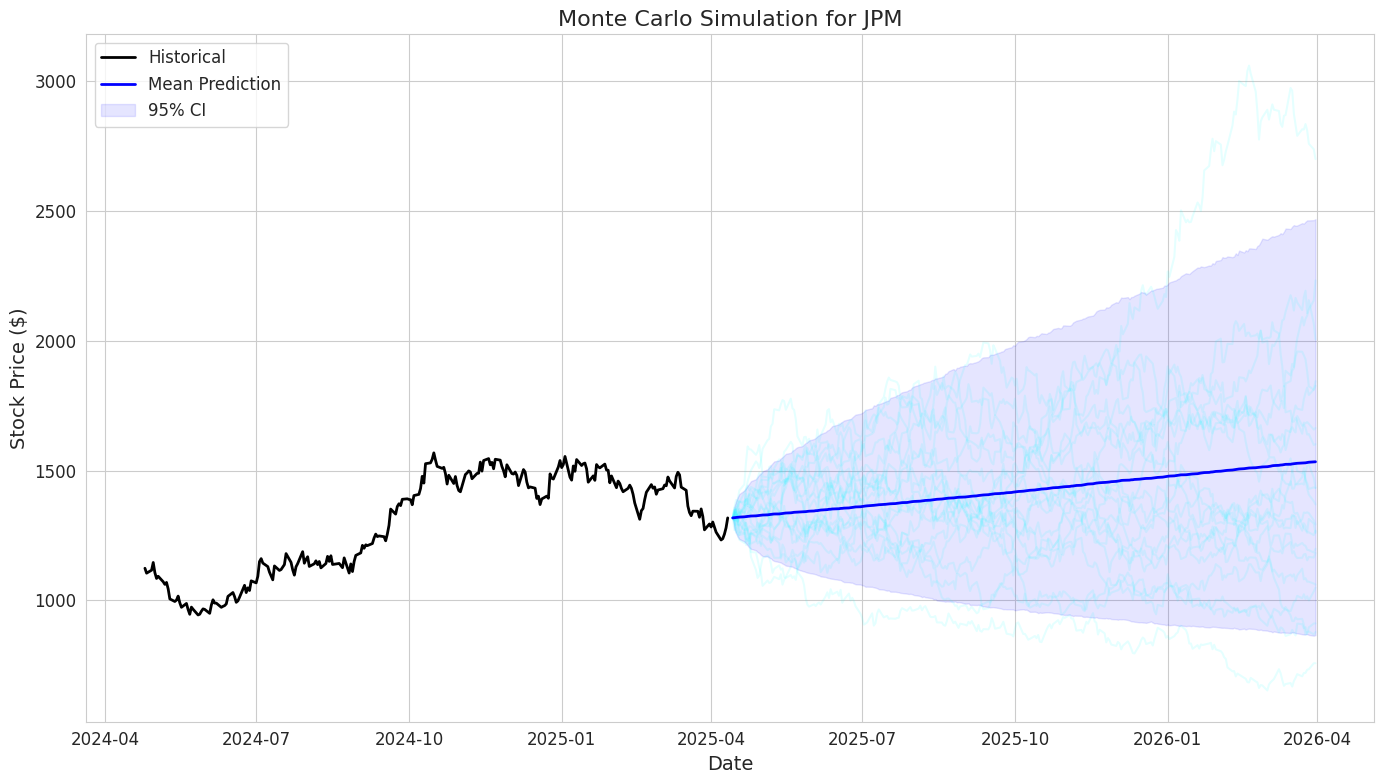

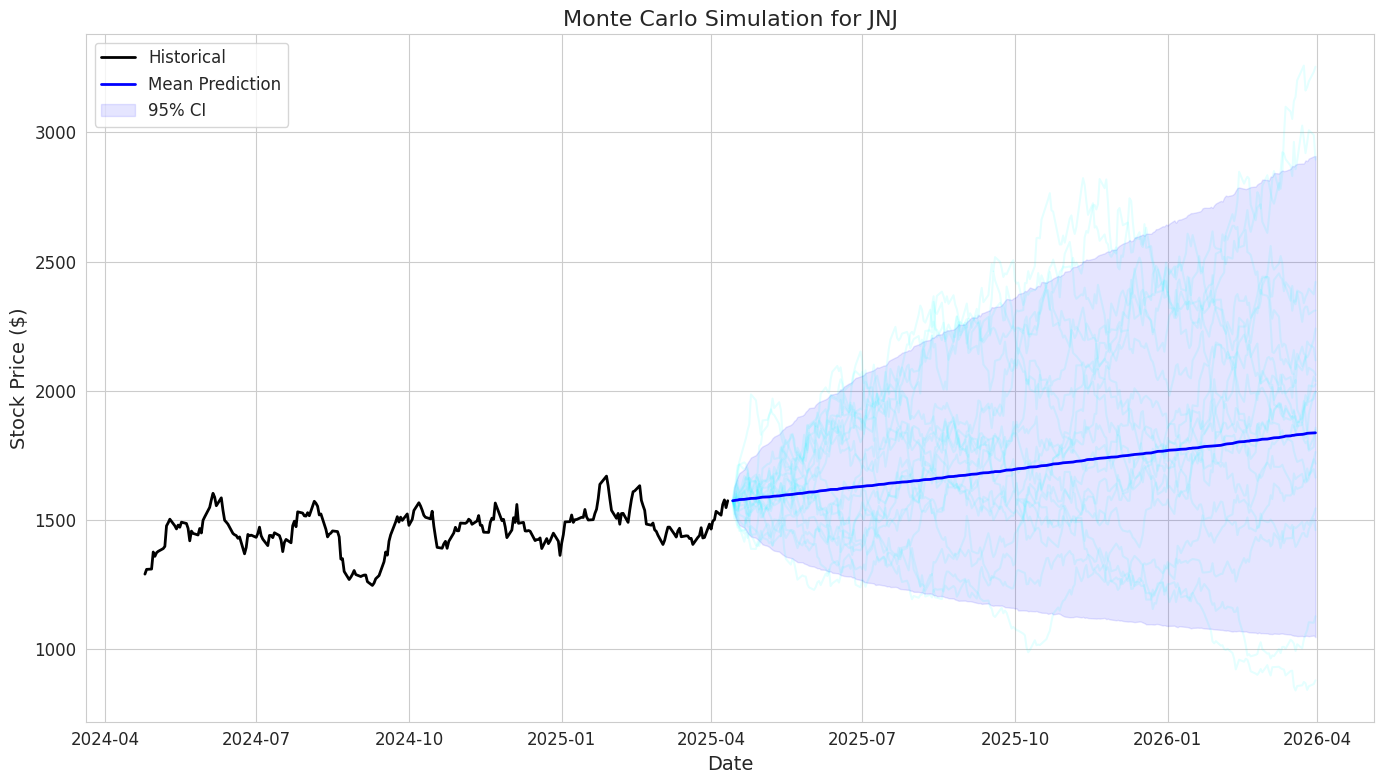

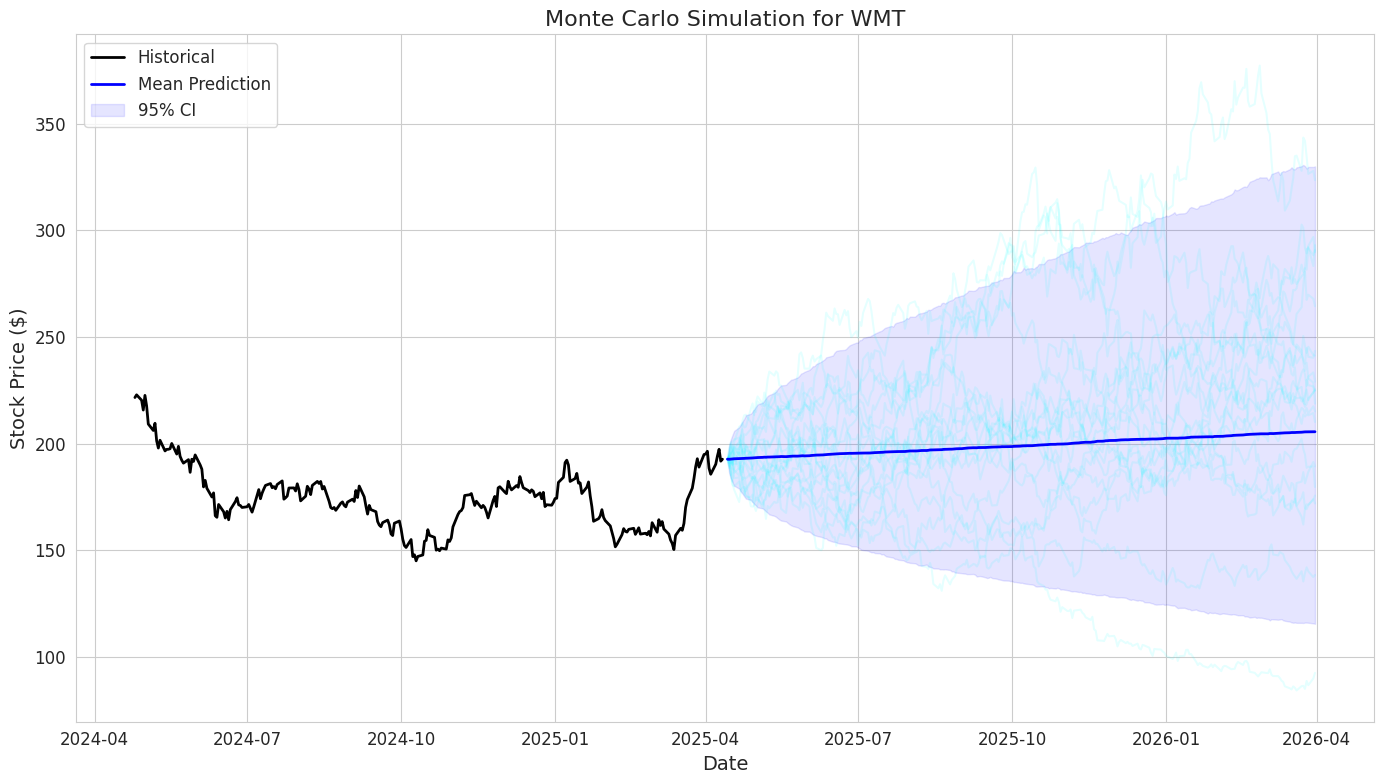

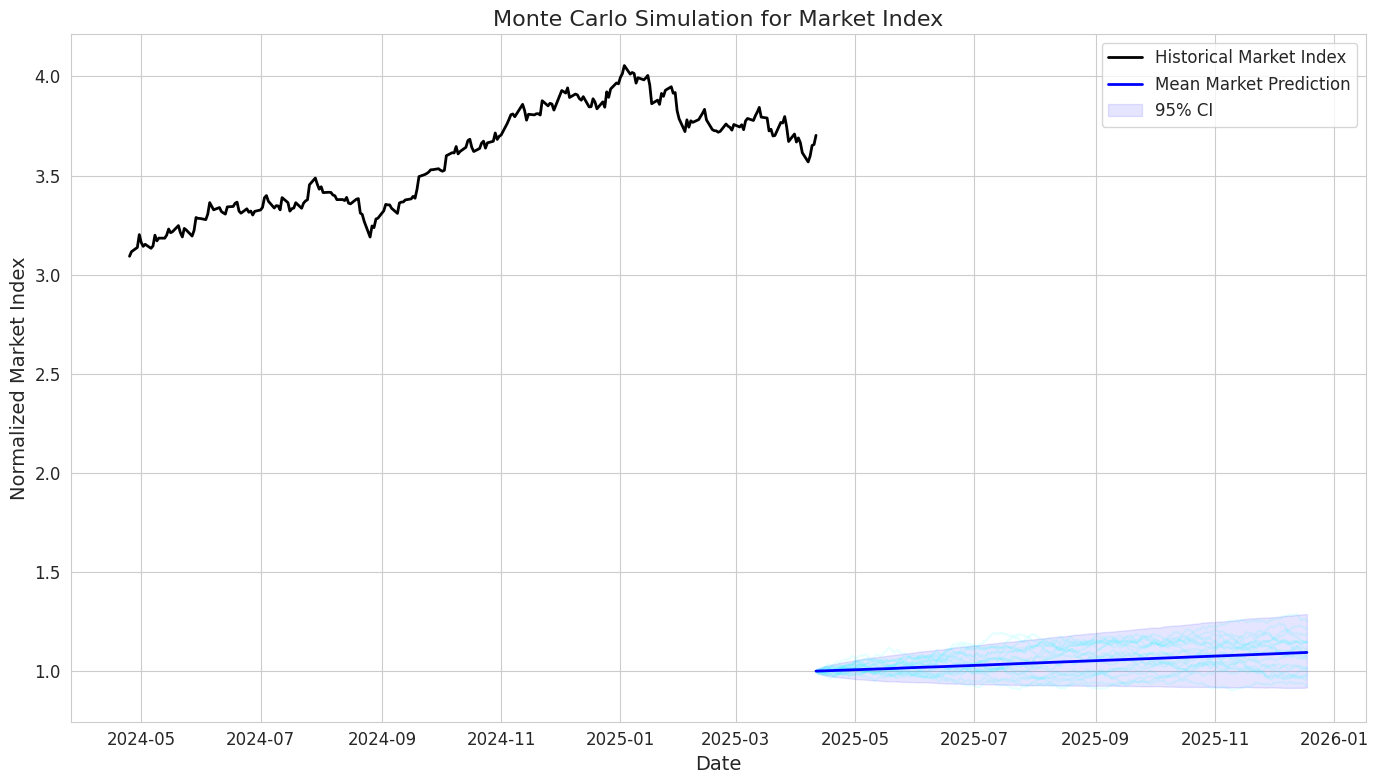


--- Performing Portfolio Optimization ---
Running portfolio optimization based on Monte Carlo simulations...


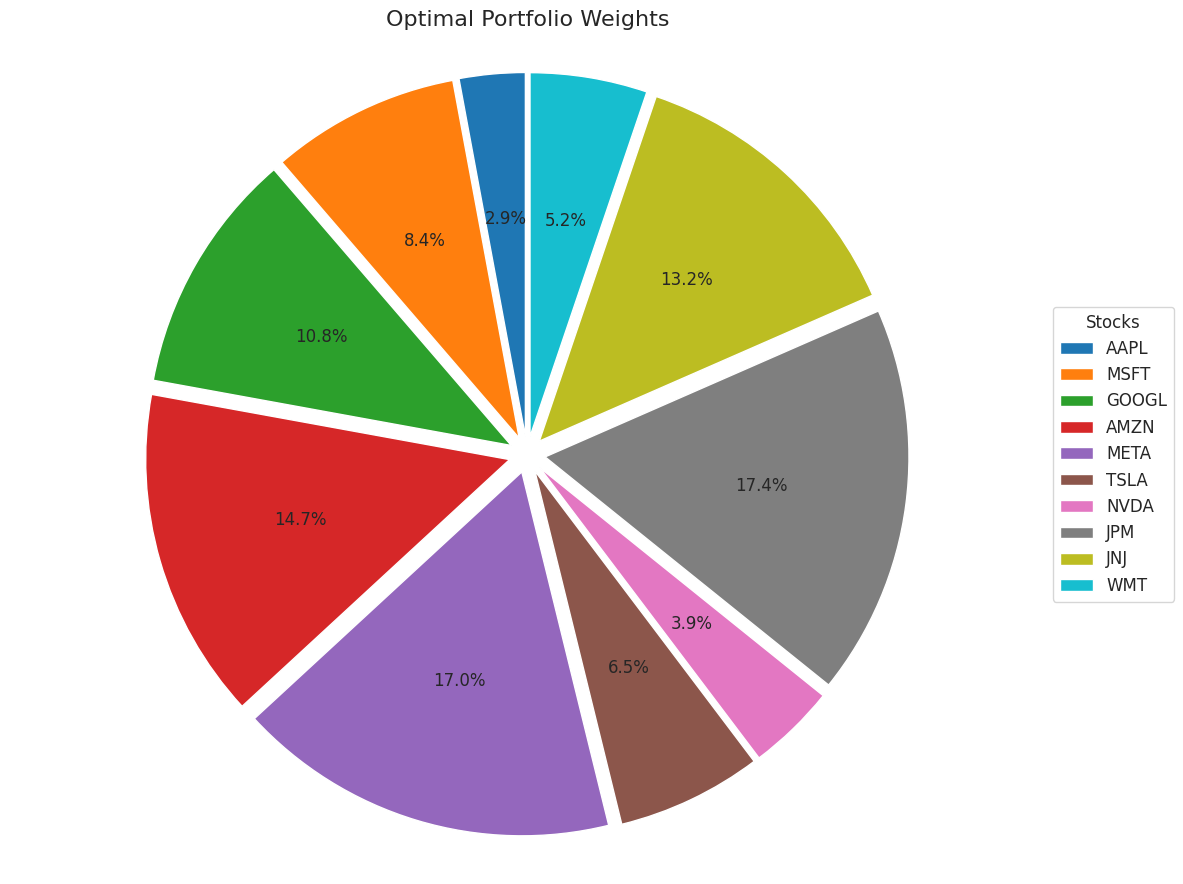


Optimal Portfolio:
  AAPL: 2.92%
  MSFT: 8.39%
  GOOGL: 10.82%
  AMZN: 14.73%
  META: 16.98%
  TSLA: 6.46%
  NVDA: 3.92%
  JPM: 17.35%
  JNJ: 13.23%
  WMT: 5.20%
Expected Annual Return: 11.45%
Expected Annual Volatility: 1.12%
Sharpe Ratio: 10.23

Simulation completed successfully!


In [12]:
# Main function
def main():
    print("Starting Monte Carlo Stock Price Simulation with CUDA")
    print(f"Number of simulations: {NUM_SIMULATIONS}")
    print(f"Prediction horizon: {PREDICTION_DAYS} days")
    
    # 1. Load stock data
    #stock_data = load_stock_data(SYMBOLS)
    # for symbol in stock_data:
    #     print(f"\nData for {symbol}:")
    #     print(f"Number of records: {len(stock_data[symbol])}")
    #     print(f"First few values:\n{stock_data[symbol].head()}")
    #     print(f"Last few values:\n{stock_data[symbol].tail()}")

    #save_stock_data(stock_data)
    stock_data =  load_saved_stock_data("/kaggle/input/stock-data/stock_data.pkl")  
    # 2. Calculate stock statistics
    stock_stats = calculate_stock_statistics(stock_data)
    #print(stock_stats)
    
    # 3. Run CPU simulations
    print("\n--- Running CPU Simulations ---")
    cpu_results, cpu_times = run_all_simulations(stock_stats, PREDICTION_DAYS, NUM_SIMULATIONS, use_gpu=False)
    
    # 4. Run GPU simulations
    print("\n--- Running GPU Simulations with CUDA ---")
    gpu_results, gpu_times = run_all_simulations(stock_stats, PREDICTION_DAYS, NUM_SIMULATIONS, use_gpu=True)
    
    # 5. Compare performance
    print("\n--- Comparing Performance ---")
    compare_performance(cpu_times, gpu_times)
    
    # Calculate total speedup
    total_cpu_time = sum(cpu_times.values())
    total_gpu_time = sum(gpu_times.values())
    overall_speedup = total_cpu_time / total_gpu_time
    
    print(f"Total CPU time: {total_cpu_time:.2f}s")
    print(f"Total GPU time: {total_gpu_time:.2f}s")
    print(f"Overall speedup: {overall_speedup:.2f}x")
    
    # Visualize results
    print("\n--- Generating Visualizations ---")
    visualize_simulation_results(stock_data, gpu_results, PREDICTION_DAYS)
    visualize_market_prediction(stock_data, gpu_results, PREDICTION_DAYS)
    
    
    print("\n--- Performing Portfolio Optimization ---")
    optimal_portfolio = portfolio_optimization(gpu_results)
    
    print("\nOptimal Portfolio:")
    for symbol, weight in optimal_portfolio['weights'].items():
        print(f"  {symbol}: {weight*100:.2f}%")
    print(f"Expected Annual Return: {optimal_portfolio['return']*100:.2f}%")
    print(f"Expected Annual Volatility: {optimal_portfolio['volatility']*100:.2f}%")
    print(f"Sharpe Ratio: {optimal_portfolio['sharpe_ratio']:.2f}")
    
    print("\nSimulation completed successfully!")

if __name__ == "__main__":
    main()